In [9]:
!pip install pyodbc

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [10]:
!pip install python-decouple

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
import pyodbc as pyodbc
from decouple import config

DB_SERVER = config('DB_SERVER', default='localhost')
DB_PORT = config('DB_PORT', default='1433')
DB_NAME = config('DB_NAME', default='dbname')
DB_USER = config('DB_USER', default='username')
DB_PASSWORD = config('DB_PASSWORD', default='password')

connStr = ('DRIVER={SQL Server Native Client 10.0};Server=%s;port=%s;Network Library=DBMSSOCN;Database=%s;uid=%s;pwd=%s;') % (DB_SERVER, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr)
cursor = cnxn.cursor()
print(cnxn, cursor)

DRIVER={SQL Server Native Client 10.0};Server=172.25.0.124\DESA;port=60388;Network Library=DBMSSOCN;Database=ReplCS;uid=uniconuser01;pwd=87654321;
<pyodbc.Connection object at 0x03BBE3E0> <pyodbc.Cursor object at 0x044B7DE0>


In [8]:
cursor.execute("SELECT * from TOAT.toat.mrc;")
cursor.fetchall()

[(1, 'UNICON', 'ACT', 'http://192.168.9.131:7001', 'jcabrera', datetime.datetime(2015, 11, 25, 16, 23, 5, 763000), 'ADMINSEG', datetime.datetime(2015, 11, 25, 16, 23, 5, 763000), 'unicon.com.pe', 'logoUniconFooter.png', 'Panamericana Sur Km 11.400, San Juan de Miraflores, Lima 29 | Central Telefonica: (511) 215-4600', 'https://www.facebook.com/UNICON-Profesionales-en-Concreto-211556922221542/ - https://www.linkedin.com/company/union-de-concreteras-s-a-?trk=nav_account_sub_nav_company_admin', '[SQLCOP04]', '[VMX_UNMONRB101_64].[CMDPROD]'),
 (2, 'CONCREMAX', 'ACT', 'http://192.168.63.54:7001', 'jcabrera', datetime.datetime(2015, 11, 25, 16, 23, 5, 763000), 'ADMINSEG', datetime.datetime(2015, 11, 25, 16, 23, 5, 763000), 'concremax.com.pe', 'logoConcremaxFooter.png', 'Coop. Las Vertientes Mz F, Lt. 3A - Villa El Salvador (Alt. KM. 18.5 Panamericana Sur) | Central Telefonica: 217-2700', 'https://www.facebook.com/CONCREMAX-SA-157764134239714/?ref=hl - https://www.linkedin.com/company/1974308

In [3]:
import textwrap
sql = textwrap.dedent("""
select order_date, order_code, tkt_code, truck_code, roworder, log_date_sender, log_date_receiver, 
	COALESCE(cast(DATEDIFF(SECOND, log_date_sender, log_date_receiver) as bigint), -1)  as diff
from [ReplCS].[toat].[tmp_queue_sender_receiver2] with(nolock)
where  1=1
	and order_date between '2018-04-01' and '2018-04-09'
    and truck_code not in ('705','516','247','442','631','216','239','263','267','709','476','633','265','645','304','307')
""")

In [4]:
import pandas as pd
dfQueue = pd.read_sql(sql, cnxn)
print(dfQueue.head())

  order_date order_code tkt_code truck_code  roworder         log_date_sender  \
0 2018-04-02        120    50674        751       139 2018-04-02 09:50:07.360   
1 2018-04-02        120    50674        751       140 2018-04-02 09:51:07.590   
2 2018-04-02        120    50674        751       141 2018-04-02 09:52:07.840   
3 2018-04-02        120    50674        751       142 2018-04-02 09:53:08.057   
4 2018-04-02        120    50674        751       143 2018-04-02 09:54:08.287   

        log_date_receiver  diff  
0 2018-04-02 09:50:46.547    39  
1 2018-04-02 09:51:36.437    29  
2 2018-04-02 09:52:26.870    19  
3 2018-04-02 09:53:26.340    18  
4 2018-04-02 09:54:26.447    18  


In [6]:
%matplotlib inline
# df.set_index(['order_date', 'order_code', 'tkt_code', 'truck_code'], inplace=True)
# df = df.drop("reg_date", axis=1)
print(dfQueue.shape)

(470950, 8)


In [7]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
# print(dfQueue[['order_date','diff']])
# dfQueue.plot(x='order_date', y='diff')
# plt.show()

In [8]:
df2 = dfQueue[['order_date','diff']]
print(df2.head())

  order_date  diff
0 2018-04-02    39
1 2018-04-02    29
2 2018-04-02    19
3 2018-04-02    18
4 2018-04-02    18


In [9]:
df2.set_index(['order_date'], inplace=True)

In [10]:
df2[df2['diff'].notnull()].groupby(['order_date'])['diff'].mean()

order_date
2018-04-01    12.049420
2018-04-02    25.095133
2018-04-03    23.751268
2018-04-04    24.007489
2018-04-05    23.999407
2018-04-06    24.542797
2018-04-07    22.788478
2018-04-08    14.552941
2018-04-09    23.679262
Name: diff, dtype: float64

In [11]:
df2[df2['diff']>=0].groupby(['order_date'])['diff'].mean()

order_date
2018-04-01    16.246413
2018-04-02    26.639839
2018-04-03    26.369977
2018-04-04    26.732643
2018-04-05    26.878206
2018-04-06    27.007874
2018-04-07    25.690845
2018-04-08    14.552941
2018-04-09    26.940702
Name: diff, dtype: float64

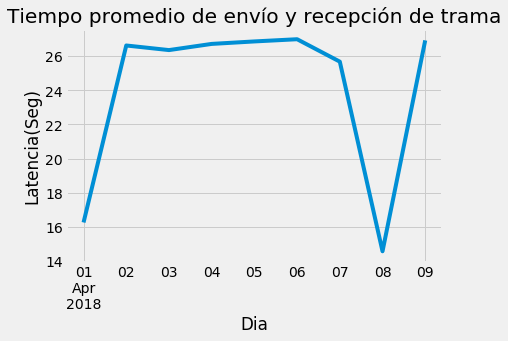

In [13]:
gf = df2[df2['diff']>=0].groupby(['order_date'])['diff'].mean().plot(legend=False)
gf.set_title("Tiempo promedio de envío y recepción de trama")
gf.set_xlabel("Dia")
gf.set_ylabel("Latencia(Seg)")
plt.show()

In [14]:
print(df2.shape)
print(df2[df2['diff'].notnull()].shape)
print(df2[df2['diff'].isnull()].shape)
print(df2[df2['diff']>0].shape)
print(df2[df2['diff']==0].shape)
print(df2[df2['diff']<0].shape)

(470950, 1)
(470950, 1)
(0, 1)
(423525, 1)
(2297, 1)
(45128, 1)


In [15]:
df2[df2['diff']<0].head()

diff
order_date      
2018-04-02    -1
2018-04-02    -1
2018-04-02    -1
2018-04-02    -1
2018-04-02    -1

In [17]:
df2[df2['diff']<0].groupby(['order_date'])['diff'].count()

order_date
2018-04-01     650
2018-04-02    3476
2018-04-03    6812
2018-04-04    6718
2018-04-05    7319
2018-04-06    6729
2018-04-07    5840
2018-04-09    7584
Name: diff, dtype: int64

In [18]:
dfNullVals = df2[df2['diff']<0].groupby(['order_date'])['diff'].count().reset_index()

In [19]:
from datetime import datetime
dfNullVals
# dfNullVals.set_value(pd.Timestamp(datetime(2018, 4, 8)), 0)

order_date  diff
0 2018-04-01   650
1 2018-04-02  3476
2 2018-04-03  6812
3 2018-04-04  6718
4 2018-04-05  7319
5 2018-04-06  6729
6 2018-04-07  5840
7 2018-04-09  7584

In [20]:
dfRow = pd.DataFrame({'order_date' : pd.Timestamp(datetime(2018, 4, 8)), 'diff' : 0}, index=[8])
dfRow

diff order_date
8     0 2018-04-08

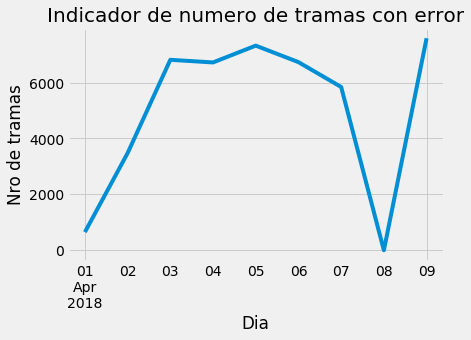

In [22]:
gf = pd.concat([dfNullVals, dfRow]).sort_values('order_date').set_index(['order_date']).plot(legend=False)
gf.set_title("Indicador de numero de tramas con error", fontsize=20)
gf.set_xlabel("Dia")
gf.set_ylabel("Nro de tramas")
plt.show()

In [23]:
pd.concat([dfNullVals, dfRow]).sort_values('order_date').set_index(['order_date'])

diff
order_date      
2018-04-01   650
2018-04-02  3476
2018-04-03  6812
2018-04-04  6718
2018-04-05  7319
2018-04-06  6729
2018-04-07  5840
2018-04-08     0
2018-04-09  7584

In [24]:
pd.concat([dfNullVals, dfRow]).sort_values('order_date').set_index(['order_date'])['diff']

order_date
2018-04-01     650
2018-04-02    3476
2018-04-03    6812
2018-04-04    6718
2018-04-05    7319
2018-04-06    6729
2018-04-07    5840
2018-04-08       0
2018-04-09    7584
Name: diff, dtype: int64

In [25]:
df2.groupby(['order_date'])['diff'].count()

order_date
2018-04-01     2671
2018-04-02    62197
2018-04-03    71197
2018-04-04    68366
2018-04-05    70877
2018-04-06    76454
2018-04-07    53706
2018-04-08      510
2018-04-09    64972
Name: diff, dtype: int64

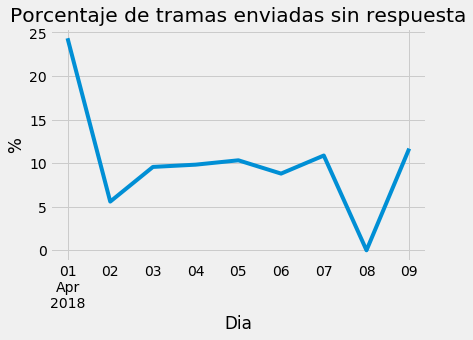

In [26]:
dfError = pd.concat([dfNullVals, dfRow]).sort_values('order_date').set_index(['order_date'])['diff']
dfTotal = df2.groupby(['order_date'])['diff'].count()
dfResult = (dfError / dfTotal) * 100
gf = dfResult.plot(title='Porcentaje de tramas enviadas sin respuesta')
gf.set_xlabel("Dia")
gf.set_ylabel("%")
# plt.suptitle('Your Title Here rgesgh sth set hs ths eth wr thwtrh j', fontsize='xx-large')
# plt.title('The title with font size: 20, and font:monospace')
plt.show()

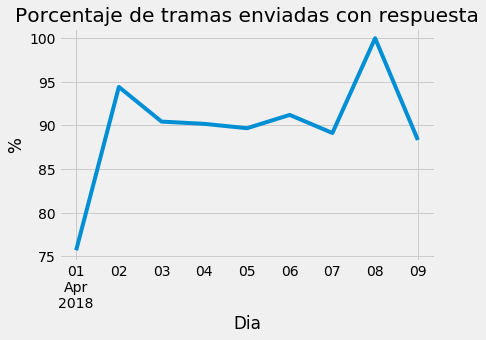

In [27]:
dfOk = df2[df2['diff']>=0].groupby(['order_date'])['diff'].count()
dfResultOk = (dfOk / dfTotal) * 100
gf = dfResultOk.plot(title='Porcentaje de tramas enviadas con respuesta')
gf.set_xlabel("Dia")
gf.set_ylabel("%")
plt.show()

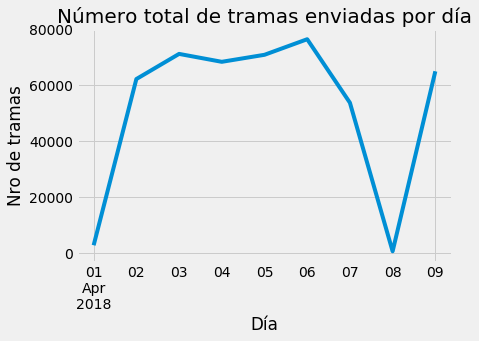

In [30]:
gf = dfTotal.plot(legend=False)
gf.set_title("Número total de tramas enviadas por día", fontsize=20)
gf.set_xlabel("Día")
gf.set_ylabel("Nro de tramas")
plt.show()

In [39]:
dfTotal

order_date
2018-04-01     2671
2018-04-02    62197
2018-04-03    71197
2018-04-04    68366
2018-04-05    70877
2018-04-06    76454
2018-04-07    53706
2018-04-08      510
2018-04-09    64972
Name: diff, dtype: int64